In [1]:
import random, re, string, itertools, timeit, sacrebleu
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from IPython.display import display, clear_output
from sklearn.model_selection import train_test_split

# Tensorflow & Keras
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dense, LSTM, LSTMCell
from tensorflow.keras.layers import Embedding, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam


plt.style.use('seaborn-pastel')

In [2]:
with open('/kaggle/input/sample-dataset/formal','r') as f:
    lines1 = f.readlines()

In [3]:
data = open('/kaggle/input/sample-dataset/formal', encoding='utf-8').\
        read().strip().split('\n')

In [4]:
pairs = [[s for s in l.split('\t')[:2]] for l in data]
pairs[100:110]

[['Something to look at or play with.'],
 ['My dress was long wit ha fifteen foot train!'],
 ['You will be happy when you communicate and be yourself.'],
 ['You still got the wrong answer, even though you thought that you had the right answer.'],
 ["Last time i was injured, so it's just me this time."],
 ['Call him and talk with him about the matter.'],
 ["Most likely, you'll never find a significant other that likes you for your personality, or even if you like him."],
 ['Just explain to them that you love them very much.'],
 ["It would have to be someone that I'm familiar with."],
 ["Do you even know her? She doesn't feel the same way about you. You should talk with her."]]

In [5]:
for i in range(len(lines1)):
    lines1[i] = lines1[i].rstrip()

In [6]:
df1 = pd.DataFrame(lines1,columns=['formal'])

In [7]:
df1

,formal
0,I prefer to let the guy ask me.
1,I suffer through verbal abuse from my wife.
2,You will have more friends than you want.
3,It's nice that you get to see pictures of who ...
4,I need to know what to do.
...,...
51962,"Of course, it depends on what type of relation..."
51963,"Wear a sign that say ""Hi!"""
51964,I do not like when guys play games with me.
51965,How old are you?


In [8]:
with open('/kaggle/input/sample-dataset/informal','r') as f:
    lines2 = f.readlines()

In [9]:
for i in range(len(lines2)):
    lines2[i] = lines2[i].rstrip()

In [10]:
df2 = pd.DataFrame(lines2,columns=['informal'])

In [11]:
l = [list(x) + list(y) for x, y in zip(df1.values, df2.values)]
l[100:110]

[['Something to look at or play with.', 'something to look at or play with'],
 ['My dress was long wit ha fifteen foot train!',
  'My Dress was long with a 15 foot train!'],
 ['You will be happy when you communicate and be yourself.',
  'All you have to do is comunicate and be yourself and you will be happy'],
 ['You still got the wrong answer, even though you thought that you had the right answer.',
  'When you started to think that right..........that time it self you...ur self got the answer which is wroung.'],
 ["Last time i was injured, so it's just me this time.",
  'i got hurt pretty bad last time so it is just me.'],
 ['Call him and talk with him about the matter.',
  'call him & talk to him about it.'],
 ["Most likely, you'll never find a significant other that likes you for your personality, or even if you like him.",
  "u'll almost never find a guy that likes you for you and not because you like him."],
 ['Just explain to them that you love them very much.',
  'just tell the

In [12]:
mispell_dict = {
    "aren't" : "are not",
    "can't" : "cannot",
    "couldn't" : "could not",
    "didn't" : "did not",
    "doesn't" : "does not",
    "don't" : "do not",
    "hadn't" : "had not",
    "hasn't" : "has not",
    "haven't" : "have not",
    "he'd" : "he would",
    "he'll" : "he will",
    "he's" : "he is",
    "i'd" : "i would",
    "i'd" : "i had",
    "i'll" : "i will",
    "i'm" : "i am",
    "isn't" : "is not",
    "it's" : "it is",
    "it'll":"it will",
    "i've" : "i have",
    "let's" : "let us",
    "mightn't" : "might not",
    "mustn't" : "must not",
    "shan't" : "shall not",
    "she'd" : "she would",
    "she'll" : "she will",
    "she's" : "she is",
    "shouldn't" : "should not",
    "that's" : "that is",
    "there's" : "there is",
    "they'd" : "they would",
    "they'll" : "they will",
    "they're" : "they are",
    "they've" : "they have",
    "we'd" : "we would",
    "we're" : "we are",
    "weren't" : "were not",
    "we've" : "we have",
    "what'll" : "what will",
    "what're" : "what are",
    "what's" : "what is",
    "what've" : "what have",
    "where's" : "where is",
    "who'd" : "who would",
    "who'll" : "who will",
    "who're" : "who are",
    "who's" : "who is",
    "who've" : "who have",
    "won't" : "will not",
    "wouldn't" : "would not",
    "you'd" : "you would",
    "you'll" : "you will",
    "you're" : "you are",
    "you've" : "you have",
    "'re": " are",
    "wasn't": "was not",
    "we'll":" will",
    "didn't": "did not",
    "tryin'":"trying"
}

mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))

def preprocess(text) -> str:
    def replace(match):
        return mispell_dict[match.group(0)]
    
    text = mispell_re.sub(replace, text)
    return text

In [13]:
data = [x for x in l if len(x) == 2]
formal = [preprocess(x[0]) for x in data]
informal = [preprocess(x[1]) for x in data]



In [14]:
formal_train, formal_test, informal_train, informal_test = \
train_test_split(formal, informal, test_size = 0.04, random_state = 42)

print(f"Splitting to {len(formal_train)} Train data and \
{len(formal_test)} Test data")


Splitting to 49888 Train data and 2079 Test data


In [15]:
# !pip -q install sacrebleu
# !pip -q install googletrans
# !pip -q install tensorflow-addons --upgrade

In [16]:
formal_train = ['bos '+ x + ' eos' for x in formal_train + ['unk unk unk']]
informal_train = ['bos '+ x + ' eos' for x in informal_train + ['unk unk unk']]

formal_val = ['bos '+ x + ' eos' for x in formal_test]
informal_val = ['bos '+ x + ' eos' for x in informal_test]


In [17]:
# English Tokenizer
formal_tokenizer = Tokenizer(filters='')
formal_tokenizer.fit_on_texts(formal_train)
informal_tokenizer = Tokenizer(filters='')
informal_tokenizer.fit_on_texts(informal_train)



In [18]:
print(f'formal vocab size   :', len(formal_tokenizer.word_index) - 3)
print(f'informal vocab size   :', len(informal_tokenizer.word_index) - 3)

formal vocab size   : 25707
informal vocab size   : 34207


In [19]:
def Sequences(texts, tokenizer):
    res = []
    for text in texts:
        seq = []
        for w in text.split():
            try:
                seq.append(tokenizer.word_index[w])
            except:
                seq.append(tokenizer.word_index['unk'])
        res.append(seq)
    return res

In [20]:
# Transform Sentences to Sequences
data_formal = formal_tokenizer.texts_to_sequences(formal_train)
data_informal = informal_tokenizer.texts_to_sequences(informal_train)

val_formal = Sequences(formal_val, formal_tokenizer)
val_informal = Sequences(informal_val, informal_tokenizer)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  This is separate from the ipykernel package so we can avoid doing imports until


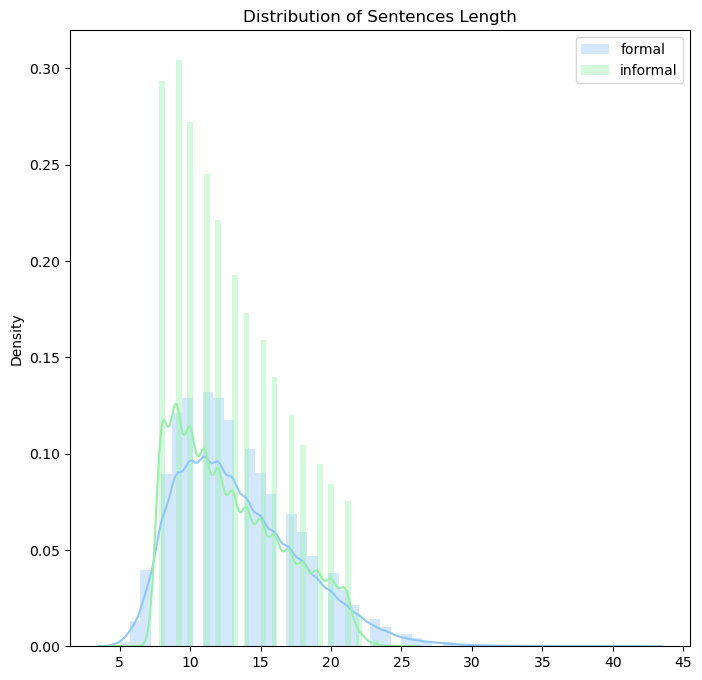

In [21]:
plt.figure(figsize = (8,8))
sns.distplot([len(x) for x in data_formal], label='formal')
sns.distplot([len(x) for x in data_informal], label='informal')
plt.title('Distribution of Sentences Length')
plt.legend()
plt.show()

based on the distplot informal sentences contains about 20 - 40 words while formal have more wider range.



In [22]:
max_formal = max([len(x) for x in data_formal] + [len(x) for x in val_formal])
max_informal = max([len(x) for x in data_informal] + [len(x) for x in val_informal])

print(f'Maximum length of formal sequences is  {max_formal}')
print(f'Maximum length of informal sequences is {max_informal}')

Maximum length of formal sequences is  42
Maximum length of informal sequences is 25


In [23]:
# Padding Sequences
data_formal = pad_sequences(data_formal, padding='post', maxlen = max_formal)
data_informal = pad_sequences(data_informal, padding='post', maxlen = max_informal)

val_formal = pad_sequences(val_formal, padding='post', maxlen = max_formal)
val_informal = pad_sequences(val_informal, padding='post', maxlen = max_informal)


In [24]:
# Config
epochs = 10
BATCH_SIZE = 64
BUFFER_SIZE = len(data_informal)
steps_per_epoch = BUFFER_SIZE//BATCH_SIZE
val_steps_per_epoch = len(val_informal) // BATCH_SIZE
embedding_dims = 256
rnn_units = 1024
dense_units = 1024
Dtype = tf.float32

In [25]:
def max_len(tensor):
    """
    Get max len in Sequences
    """
    return max( len(t) for t in tensor)


In [26]:
# Max Len
Tx = max_len(data_formal)
Ty = max_len(data_informal)

# Vocab
input_vocab_size = len(formal_tokenizer.word_index) + 1   # formal
output_vocab_size = len(informal_tokenizer.word_index) + 1  # informal

# Changging to TF data
dataset = (tf.data.Dataset.from_tensor_slices((data_formal, data_informal))
           .shuffle(BUFFER_SIZE)
           .batch(BATCH_SIZE, drop_remainder=True)
          )

val_dataset = (tf.data.Dataset.from_tensor_slices((val_formal, val_informal))
               .batch(BATCH_SIZE)
              )

In [27]:
#ENCODER
class EncoderNetwork(tf.keras.Model):
    def __init__(self,input_vocab_size,embedding_dims, rnn_units ):
        super().__init__()
        self.encoder_embedding = Embedding(input_dim=input_vocab_size,
                                           output_dim=embedding_dims)
        self.encoder_rnnlayer = LSTM(rnn_units,return_sequences=True,
                                     return_state=True )
    
#DECODER
class DecoderNetwork(tf.keras.Model):
    def __init__(self,output_vocab_size, embedding_dims, rnn_units):
        super().__init__()
        self.decoder_embedding = Embedding(input_dim=output_vocab_size,
                                           output_dim=embedding_dims) 
        self.dense_layer = Dense(output_vocab_size)
        self.decoder_rnncell = LSTMCell(rnn_units)
        # Sampler
        self.sampler = tfa.seq2seq.sampler.TrainingSampler()
        # Create attention mechanism with memory = None
        self.attention_mechanism = \
            self.build_attention_mechanism(dense_units,None,BATCH_SIZE*[Tx])
        self.rnn_cell = self.build_rnn_cell(BATCH_SIZE)
        self.decoder = tfa.seq2seq.BasicDecoder(self.rnn_cell,
                                                sampler= self.sampler,
                                                output_layer = self.dense_layer
                                               )

    def build_attention_mechanism(self, units, memory, MSL):
        """
        MSL : Memory Sequence Length
        """
        #return tfa.seq2seq.LuongAttention(units, memory = memory, 
        #                                  memory_sequence_length = MSL)
        return tfa.seq2seq.BahdanauAttention(units, memory = memory, 
                                             memory_sequence_length = MSL)

    # wrap decodernn cell  
    def build_rnn_cell(self, batch_size):
        return tfa.seq2seq.AttentionWrapper(self.decoder_rnncell, 
                                            self.attention_mechanism,
                                            attention_layer_size=dense_units)
    
    def build_decoder_initial_state(self, batch_size, encoder_state, Dtype):
        decoder_initial_state = self.rnn_cell.get_initial_state(batch_size = batch_size, 
                                                                dtype = Dtype)
        decoder_initial_state = decoder_initial_state.clone(cell_state = encoder_state) 
        return decoder_initial_state


In [28]:
# Build Model
encoderNetwork = EncoderNetwork(input_vocab_size, embedding_dims, rnn_units)
decoderNetwork = DecoderNetwork(output_vocab_size, embedding_dims, rnn_units)

# Optimizer
optimizer = tf.keras.optimizers.Adam()

In [29]:
def loss_function(y_pred, y):
    #shape of y [batch_size, ty]
    #shape of y_pred [batch_size, Ty, output_vocab_size] 
    sparsecategoricalcrossentropy = SparseCategoricalCrossentropy(from_logits=True,
                                                                  reduction='none')
    loss = sparsecategoricalcrossentropy(y_true=y, y_pred=y_pred)
    mask = tf.logical_not(tf.math.equal(y,0))   #output 0 for y=0 else output 1
    mask = tf.cast(mask, dtype=loss.dtype)
    loss = mask * loss
    loss = tf.reduce_mean(loss)
    return loss

@tf.function
def train_step(input_batch, output_batch, encoder_initial_cell_state):
    # initialize loss = 0
    loss = 0
    with tf.GradientTape() as tape:
        encoder_emb_inp = encoderNetwork.encoder_embedding(input_batch)
        a, a_tx, c_tx = encoderNetwork.encoder_rnnlayer(encoder_emb_inp, 
                                                        initial_state = encoder_initial_cell_state)

        # [last step activations,last memory_state] of 
        # encoder passed as input to decoder Network
         
        # Prepare correct Decoder input & output sequence data
        decoder_input = output_batch[:,:-1] # ignore eos
        # compare logits with timestepped +1 version of decoder_input
        decoder_output = output_batch[:,1:] #ignore bos

        # Decoder Embeddings
        decoder_emb_inp = decoderNetwork.decoder_embedding(decoder_input)

        # Setting up decoder memory from encoder output 
        # and Zero State for AttentionWrapperState
        decoderNetwork.attention_mechanism.setup_memory(a)
        decoder_initial_state = decoderNetwork.build_decoder_initial_state(BATCH_SIZE,
                                                                           encoder_state=[a_tx, c_tx],
                                                                           Dtype=tf.float32)
        
        # BasicDecoderOutput        
        outputs, _, _ = decoderNetwork.decoder(decoder_emb_inp,initial_state=decoder_initial_state,
                                               sequence_length=BATCH_SIZE*[Ty-1])

        logits = outputs.rnn_output
        
        # Calculate loss
        loss = loss_function(logits, decoder_output)

    # Returns the list of all layer variables / weights.
    variables = encoderNetwork.trainable_variables + decoderNetwork.trainable_variables  
    # differentiate loss wrt variables
    gradients = tape.gradient(loss, variables)

    # grads_and_vars – List of(gradient, variable) pairs.
    grads_and_vars = zip(gradients,variables)
    optimizer.apply_gradients(grads_and_vars)
    return loss

@tf.function
def evaluate(input_batch, output_batch, encoder_initial_cell_state):
    loss = 0
    encoder_emb_inp = encoderNetwork.encoder_embedding(input_batch)
    a, a_tx, c_tx = encoderNetwork.encoder_rnnlayer(encoder_emb_inp, 
                                                    initial_state =encoder_initial_cell_state)
    decoder_input = output_batch[:,:-1]
    decoder_output = output_batch[:,1:]
    decoder_emb_inp = decoderNetwork.decoder_embedding(decoder_input)
    decoderNetwork.attention_mechanism.setup_memory(a)
    decoder_initial_state = decoderNetwork.build_decoder_initial_state(BATCH_SIZE,
                                                                       encoder_state=[a_tx, c_tx],
                                                                       Dtype=tf.float32)
    outputs, _, _ = decoderNetwork.decoder(decoder_emb_inp,initial_state=decoder_initial_state,
                                           sequence_length=BATCH_SIZE*[Ty-1])
    logits = outputs.rnn_output
    loss = loss_function(logits, decoder_output)
    return loss

In [30]:
# RNN LSTM hidden and memory state initializer
def initialize_initial_state():
    return [tf.zeros((BATCH_SIZE, rnn_units)), tf.zeros((BATCH_SIZE, rnn_units))]

In [37]:
# Translate
def Translate(input_raw):
    input_raw =preprocess(input_raw)
    input_lines = ['bos '+ input_raw + '']
    
    input_sequences, unique = [], []
    for line in input_lines:
        temp = []
        for w in line.split(' '):
            try:
                temp.append(formal_tokenizer.word_index[w])
            except: # Avoid Error
                unique.append(w)
                temp.append(informal_tokenizer.word_index['unk'])
        input_sequences.append(temp)
    
    input_sequences = pad_sequences(input_sequences, maxlen=Tx, padding='post')
    inp = tf.convert_to_tensor(input_sequences)
    inference_batch_size = input_sequences.shape[0]
    encoder_initial_cell_state = [tf.zeros((inference_batch_size, rnn_units)),
                                  tf.zeros((inference_batch_size, rnn_units))]
    encoder_emb_inp = encoderNetwork.encoder_embedding(inp)
    a, a_tx, c_tx = encoderNetwork.encoder_rnnlayer(encoder_emb_inp,
                                                    initial_state = encoder_initial_cell_state)

    start_tokens = tf.fill([inference_batch_size], informal_tokenizer.word_index['bos'])

    end_token = informal_tokenizer.word_index['eos']

    greedy_sampler = tfa.seq2seq.GreedyEmbeddingSampler()

    decoder_input = tf.expand_dims([informal_tokenizer.word_index['bos']] * inference_batch_size,1)
    decoder_emb_inp = decoderNetwork.decoder_embedding(decoder_input)

    decoder_instance = tfa.seq2seq.BasicDecoder(cell = decoderNetwork.rnn_cell, 
                                                sampler = greedy_sampler,
                                                output_layer = decoderNetwork.dense_layer)
    decoderNetwork.attention_mechanism.setup_memory(a)

    decoder_initial_state = decoderNetwork.build_decoder_initial_state(
        inference_batch_size, encoder_state=[a_tx, c_tx], Dtype=tf.float32)

    maximum_iterations = tf.round(tf.reduce_max(Tx) * 2)

    decoder_embedding_matrix = decoderNetwork.decoder_embedding.variables[0] 
    (first_finished, first_inputs,first_state) = decoder_instance.initialize(
        decoder_embedding_matrix, start_tokens = start_tokens,
        end_token = end_token, initial_state = decoder_initial_state)

    inputs = first_inputs
    state = first_state  
    predictions = np.empty((inference_batch_size,0), dtype = np.int32)                                                              
    for j in range(maximum_iterations):
        outputs, next_state, next_inputs, finished = decoder_instance.step(j, inputs,state)
        inputs = next_inputs
        state = next_state
        outputs = np.expand_dims(outputs.sample_id,axis = -1)
        predictions = np.append(predictions, outputs, axis = -1)
        
    res = ''
    for i in range(len(predictions)):
        line = predictions[i,:]
        seq = list(itertools.takewhile(lambda index: index !=2, line))
        res += " ".join( [informal_tokenizer.index_word[w] for w in seq])
    res = res.split()
    
    # Return back Unique words
    for i in range(len(res)):
        if res[i] == 'unk' and unique != []:
            res[i] = unique.pop(0)
    
    return ' '.join(res)

# Calculate BLEU
def BLEU(X, y):
    # Prediction
    pred = [Translate(w) for w in tqdm(X)]
    # Calculate BLEU 
    score = sacrebleu.corpus_bleu(pred, [y]).score / 100
    return score, pred

In [38]:
# Custom Train Progress
class Progress:
    def __init__(self):
        self.fig = plt.figure(figsize = (8,6))
        self.ax = self.fig.add_subplot(1, 1, 1)
        self.loss, self.val_loss, self.BLEU = [], [], []
        self.epoch_loss = 0
        
    def get_val_loss(self):
        return [x[1] for x in self.val_loss]
        
    # Plot
    def dynamic_plot(self):
        self.ax.cla()
        self.ax.plot(range(len(self.loss)), self.loss, label='loss')
        if len(self.val_loss) >= 1:
            x = [l[0] for l in self.val_loss]
            y = [l[1] for l in self.val_loss]
            self.ax.plot(x, y, color = 'r', label='val_loss')
            self.ax.plot(x, self.BLEU, color = 'purple', label='BLEU')
        self.ax.set_ylim(0,)
        self.ax.legend(loc = 1)
        display(self.fig)
    
    # Train step progress
    def train_progress(self, epoch, step, steps_per_epoch, start):
        self.dynamic_plot()
        print(f'Working on Epoch {epoch}')
        print('[' + ('=' * int((step + 1) / steps_per_epoch * 60)).ljust(61, ' ') 
              + f']  {step + 1}/{steps_per_epoch} - loss : {round(self.epoch_loss / step, 4)}')
        print(f'Time per Step {round(timeit.default_timer() - start, 2)} s')
        
    def summary(self):
        loss = np.array_split(np.array(self.loss), len(self.val_loss))
        loss = [np.mean(x) for x in loss]
        val_loss = [x[1] for x in self.val_loss]
        df = pd.DataFrame({'Epochs' : range(1, len(val_loss) + 1), 'loss' : loss,
                           'val loss' : val_loss, 'BLEU' : self.BLEU})
        
        self.dynamic_plot()
        clear_output(wait = True)
        display(df)

,Epochs,loss,val loss,BLEU
0,1,1.540932,2.307847,0.133095
1,2,1.249670,2.289553,0.133946
2,3,1.026206,2.552986,0.126409
3,4,0.874668,2.368890,0.120951
4,5,0.758698,2.762461,0.123252
5,6,0.662837,2.705464,0.123925
6,7,0.581605,3.152676,0.109803
7,8,0.509402,3.064805,0.112018
8,9,0.451466,3.213313,0.093930
9,10,0.401683,3.477732,0.094132


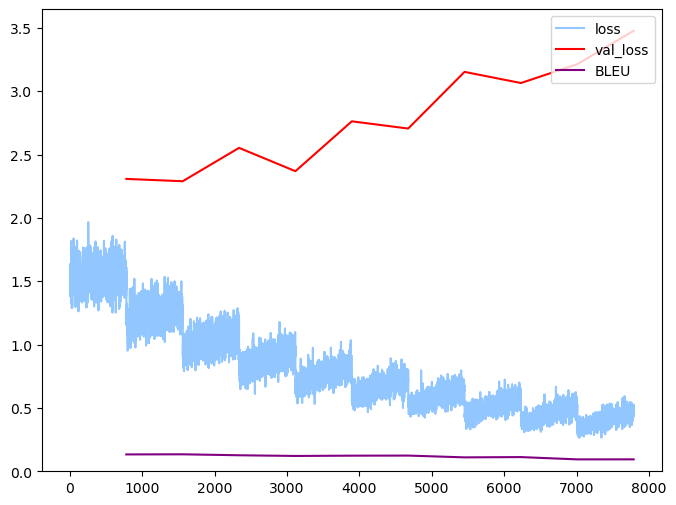

In [39]:
# Initialize Train Progress
TP = Progress()
best_prediction = []

for i in range(1, epochs + 1):

    encoder_initial_cell_state = initialize_initial_state()
    total_loss = 0.0
    # Train Loss
    TP.epoch_loss = 0

    # Train
    for (batch , (input_batch, output_batch)) in enumerate(dataset.take(steps_per_epoch)):
        start = timeit.default_timer()
        batch_loss = train_step(input_batch, output_batch, encoder_initial_cell_state)
        total_loss += batch_loss
        TP.loss.append(batch_loss.numpy())
        TP.epoch_loss += batch_loss.numpy()
            
        if (batch+1) % 30 == 0:
            TP.train_progress(i, batch, steps_per_epoch, start)
            clear_output(wait = True)
    
    # Validitate
    encoderNetwork.trainable = False  # Freeze our model layer to make sure
    decoderNetwork.trainable = False  # it didn't learn anything from val_data
    
    # Valid loss
    val_loss = 0
    for (batch, (input_batch, output_batch)) in enumerate(val_dataset.take(val_steps_per_epoch)):
        batch_loss = evaluate(input_batch, output_batch, encoder_initial_cell_state)
        val_loss += batch_loss.numpy()
    val_loss /= val_steps_per_epoch
    
    TP.val_loss.append((i * steps_per_epoch - 1, val_loss))
    
    # Bleu Score
    bleu_score, pred = BLEU(formal_test, informal_test)
    TP.BLEU.append(bleu_score)
    
    encoderNetwork.trainable = True  # Unfreeze layer for next epoch
    decoderNetwork.trainable = True
    
    # Save best model
    if bleu_score == max(TP.BLEU) and val_loss == min(TP.get_val_loss()):
        best_prediction = pred
        encoderNetwork.save_weights('encoderNetwork')
        decoderNetwork.save_weights('decoderNetwork')

TP.summary()

In [40]:
# Load best weights
encoderNetwork.load_weights('encoderNetwork')
decoderNetwork.load_weights('decoderNetwork')

In [41]:
for i in range(7,16):
    print("formal Sentence:")
    print(formal_test[i])
    print("\ninformal Translation:")
    print(best_prediction[i])
    print("\ninformal Reference:")
    print(informal_test[i])
    print(''.ljust(60, '-'))


formal Sentence:
I am fun to talk to, oh yeah baby.  My email is sexipolkadots@yahoo.com

informal Translation:
just have fun to talk to have a lot of faith...it is going to have fun

informal Reference:
I AM FUN TO TALK TOO OOHHYEAAHHBABBBYYYYY EMAIL IS:SEXIPOLKADOTS@YAHOO.COM
------------------------------------------------------------
formal Sentence:
I just wanted information on this topic.

informal Translation:
just just wanted to do is just wanted to do

informal Reference:
just wanted info on tis topic
------------------------------------------------------------
formal Sentence:
He has a baby, and she claims that they are married.

informal Translation:
has a baby and she claims that they are married...

informal Reference:
He has a baby and she claims that they are married.
------------------------------------------------------------
formal Sentence:
Add me as a contact, and then we will talk.

informal Translation:
just be a secret and then we will talk.

informal Reference:
